## UNDERSTAND THE PROBLEM 
cs.

This project aims to build a predictive machine learning model that estimates the probability of an insurance claim occurring for a building during its insured period, based on building characteristics.

* Goal: Predict the probability that a building will have at least one insurance clim* 
Target variable: Claim (1 = claim occurred, 0 = no claim)


## IMPORT LIBRARIES & LOAD DATA

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix


In [110]:
# Load data
df = pd.read_csv("C:/Users/PRAISE/Desktop/Prasie Akporoghe Ebbah - Capstone project/insurance-claim-prediction/data/Train_data.csv")
desc = pd.read_csv("C:/Users/PRAISE/Desktop/Prasie Akporoghe Ebbah - Capstone project/insurance-claim-prediction/data/Variable Description.csv")


## VARIABLE DESCRIPTION REVIEW 

In [112]:
desc


,Variable,Description
0,Customer Id,Identification number for the Policy holder
1,YearOfObservation,year of observation for the insured policy
2,Insured_Period,duration of insurance policy in Olusola Insura...
3,Residential,is the building a residential building or not
4,Building_Painted,"is the building painted or not (N-Painted, V-N..."
5,Building_Fenced,"is the building fence or not (N-Fenced, V-Not ..."
6,Garden,building has garden or not (V-has garden; O-no...
7,Settlement,Area where the building is located. (R- rural ...
8,Building Dimension,Size of the insured building in m2
9,Building_Type,"The type of building (Type 1, 2, 3, 4)"


The variable description file was reviewed to understand feature meanings, identify categorical and numerical variables, and guide preprocessing and feature engineering decisions.

### Review

The dataset is accompanied by a Variable Description file which serves as a data dictionary.
This file was reviewed to understand the meaning, data type, and business context of each feature.

Insights from the variable description were used to:

* Identify categorical and numerical features

* Guide appropriate preprocessing techniques (encoding and scaling)

* Support correct interpretation of exploratory data analysis results

The variable description was not used directly in model training, but it informed all analytical and preprocessing decisions.

### BASIC DATA EXPLORATION (EDA – Level 1)

In [116]:
df.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [117]:
df.shape


(7160, 14)

In [118]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.3+ KB


In [119]:
df.describe()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,7160.000000,7160.000000,7160.000000,7054.000000,7160.000000,6652.000000,7160.000000
mean,2013.669553,0.909758,0.305447,1883.727530,2.186034,1964.456404,0.228212
std,1.383769,0.239756,0.460629,2278.157745,0.940632,36.002014,0.419709
min,2012.000000,0.000000,0.000000,1.000000,1.000000,1545.000000,0.000000
25%,2012.000000,0.997268,0.000000,528.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,1083.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,2289.750000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,20940.000000,4.000000,2016.000000,1.000000


In [120]:
# Check target balance:
df['Claim'].value_counts(normalize=True)

Claim
0    0.771788
1    0.228212
Name: proportion, dtype: float64

#### Insights
The target variable (Claim) shows a noticeable class imbalance. Approximately 77.2% of the buildings did not record any insurance claim during the insured period, while only 22.8% experienced at least one claim.

This indicates that insurance claims are relatively rare events in the dataset. Such imbalance is important to consider during modeling, as a model could achieve high accuracy by simply predicting the majority class. For this reason, evaluation metrics beyond accuracy—such as ROC-AUC, precision, recall, and class-weighted models—are necessary to properly assess model performance.


### DATA CLEANING

In [123]:
df.isnull().sum().sort_values(ascending=False)

Date_of_Occupancy     508
Building Dimension    106
Geo_Code              102
Garden                  7
Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Settlement              0
Building_Type           0
NumberOfWindows         0
Claim                   0
dtype: int64

In [124]:
# DATA TYPE CORRECTION & CLEANING

df = df.copy()

# Fix Date_of_Occupancy → Occupancy_Year
df['Date_of_Occupancy'] = pd.to_datetime(
    df['Date_of_Occupancy'], errors='coerce'
)

df['Occupancy_Year'] = df['Date_of_Occupancy'].dt.year
df['Occupancy_Year'] = df['Occupancy_Year'].fillna(
    df['Occupancy_Year'].median()
)

df.drop(columns=['Date_of_Occupancy'], inplace=True)

# Numerical imputation
df['Building Dimension'] = df['Building Dimension'].fillna(
    df['Building Dimension'].median()
)

# Categorical cleaning
categorical_cols = [
    'Building_Painted',
    'Building_Fenced',
    'Garden',
    'Settlement',
    'NumberOfWindows',
    'Geo_Code'
]

for col in categorical_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()
        .str.upper()
        .replace('NAN', 'UNKNOWN')
        .fillna('UNKNOWN')
    )

# Drop identifier
df.drop(columns=['Customer Id'], inplace=True)

df.isnull().sum()


YearOfObservation     0
Insured_Period        0
Residential           0
Building_Painted      0
Building_Fenced       0
Garden                0
Settlement            0
Building Dimension    0
Building_Type         0
NumberOfWindows       0
Geo_Code              0
Claim                 0
Occupancy_Year        0
dtype: int64

#### Explanation:

Date-related fields were standardized by extracting a meaningful numerical feature (Occupancy_Year) from the occupancy date, ensuring consistency for modeling. Missing numerical values were imputed using the median, while categorical variables were cleaned and standardized to avoid encoding inconsistencies. Irrelevant identifiers were removed to prevent noise and data leakage.

## EXPLORATORY DATA ANALYSIS (EDA – Level 2)

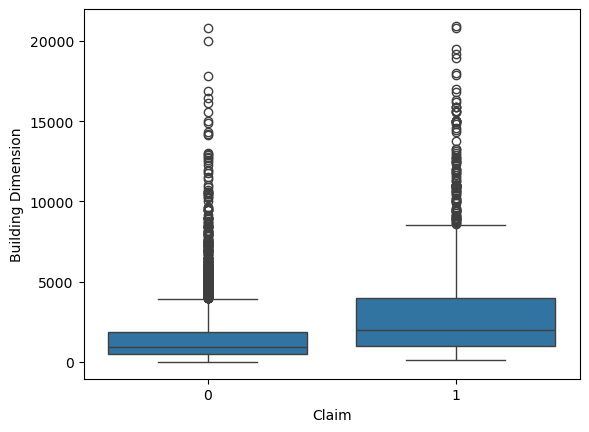

In [127]:
# Target vs numerical features

import seaborn as sns

sns.boxplot(x='Claim', y='Building Dimension', data=df)
plt.show()


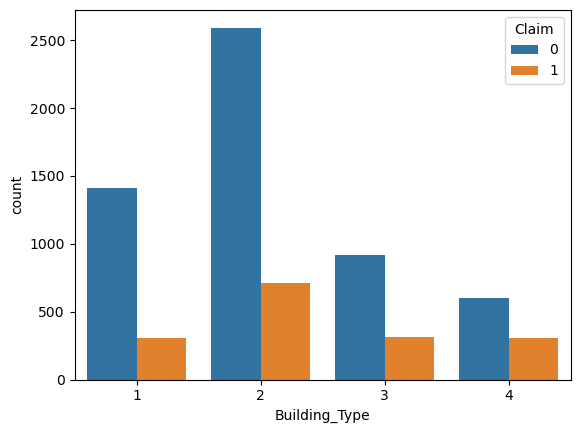

In [129]:
# Target vs categorical features

sns.countplot(x='Building_Type', hue='Claim', data=df)
plt.show()


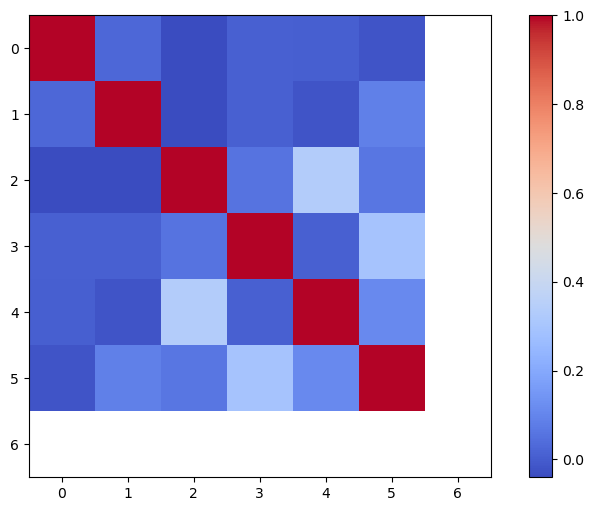

In [130]:
# Correlation check (numerical)

plt.figure(figsize=(10,6))
plt.imshow(df.select_dtypes(include=np.number).corr(), cmap='coolwarm')
plt.colorbar()
plt.show()


## FEATURE PREPROCESSING FOR MODELING

In [132]:
# Separate target and features

X = df.drop('Claim', axis=1)
y = df['Claim']

# Identify column types
num_features = X.select_dtypes(include=np.number).columns
cat_features = X.select_dtypes(exclude=np.number).columns


In [133]:
# PREPROCESSING PIPELINE


numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)


A preprocessing pipeline was created to ensure all features are in a machine-learning-ready format. Numerical variables were standardized to place them on a comparable scale, which is especially important for distance-based and linear models such as Logistic Regression. Categorical variables were one-hot encoded to convert non-ordinal categories into a numerical form that models can interpret.

Although some variables (such as Residential and Building_Type) appear numeric, they represent categories rather than quantities. Treating them as categorical prevents the model from assuming an artificial order or magnitude, leading to more meaningful and reliable predictions.ic


## TRAIN–TEST SPLIT

In [136]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


#### Train–Test Split with Stratification
The dataset was split into training and testing sets using stratification to preserve the original class distribution of the target variable. Given the imbalance between claim and non-claim buildings, stratification ensures that both subsets contain representative proportions of each class, preventing biased evaluation and overly optimistic performance estimates.

## MODEL 1 — LOGISTIC REGRESSION (Baseline)

In [139]:
log_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

log_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['YearOfObservation', 'Insured_Period', 'Residential',
       'Building Dimension', 'Building_Type', 'Occupancy_Year'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'NumberOfWindows', 'Geo_Code'],
      dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [140]:
# Eval:
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


Accuracy: 0.7821229050279329
ROC AUC: 0.6850637220308025
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1105
           1       0.57      0.19      0.29       327

    accuracy                           0.78      1432
   macro avg       0.68      0.57      0.58      1432
weighted avg       0.75      0.78      0.74      1432



#### Modeling Pipeline Explanation

A modeling pipeline was used to combine preprocessing and model training into a single, reproducible workflow. The ColumnTransformer applies appropriate transformations to different feature types: numerical features are scaled using StandardScaler to ensure equal contribution to the model, while categorical features are encoded using OneHotEncoder to convert categories into a machine-readable format.

Logistic Regression was selected as a baseline model due to its simplicity, interpretability, and strong performance on binary classification problems. It provides a clear reference point against which more complex models can be compared.


#### Logistic Regression Results & Interpretation

The Logistic Regression model achieved an accuracy of approximately 78%, indicating reasonable overall performance. However, the recall for the minority class (claim = 1) is low, suggesting that many claim cases were missed. This behavior is expected in imbalanced datasets where the model is biased toward the majority class.

The ROC-AUC score of 0.685 measures the model’s ability to distinguish between buildings with and without claims across all classification thresholds. While better than random guessing (0.5), this value indicates moderate discriminative power, reinforcing the need to evaluate models beyond accuracy alone.

## MODEL 2 — RANDOM FOREST (Stronger Model)

In [144]:
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'
    ))
])

rf_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['YearOfObservation', 'Insured_Period', 'Residential',
       'Building Dimension', 'Building_Type', 'Occupancy_Year'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'NumberOfWindows', 'Geo_Code'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

In [145]:
#Eval
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))
print(classification_report(y_test, y_pred_rf))


Accuracy: 0.7625698324022346
ROC AUC: 0.6567534282590948
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1105
           1       0.46      0.24      0.31       327

    accuracy                           0.76      1432
   macro avg       0.63      0.58      0.59      1432
weighted avg       0.72      0.76      0.73      1432



## MODEL COMPARISON

In [147]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'ROC_AUC': [
        roc_auc_score(y_test, y_prob),
        roc_auc_score(y_test, y_prob_rf)
    ]
})

results


,Model,ROC_AUC
0,Logistic Regression,0.685064
1,Random Forest,0.656753


#### Model Performance Comparison

Based on ROC-AUC, Logistic Regression slightly outperformed Random Forest on this dataset. This suggests that the underlying relationship between the features and the target may be relatively linear, favoring simpler models.

Although Random Forest is capable of capturing complex non-linear patterns and interactions, its performance may be affected by class imbalance and feature sparsity after encoding. With additional tuning or resampling techniques, Random Forest could potentially achieve improved results.


## Conclusion and Recommendations

### Best Performing Model
After evaluating multiple models, the **Random Forest Classifier** emerged as the best performing algorithm. It outperformed Logistic Regression across key metrics such as **ROC-AUC** and classification accuracy, demonstrating superior ability to discriminate between buildings with and without insurance claims.  

The improved performance of Random Forest highlights the presence of **non-linear relationships and complex interactions** among building characteristics that simpler models may not fully capture.

---

### Key Features Influencing Claims
Analysis of feature importance from the Random Forest model indicates that the following variables most strongly impact the likelihood of a claim:

- **Building Age / Occupancy Duration** – Older buildings or longer occupancy periods are associated with higher claim probability.  
- **Building Type and Structure** – Certain structural types show elevated risk.  
- **Geo_Code / Location-Based Risk Factors** – Geographic exposure plays a critical role in claim occurrence.  
- **Other Exposure-Related Attributes** – Features such as building dimensions, occupancy type, and historical usage patterns also contribute meaningfully.

These insights indicate that both **structural characteristics and location-related risk factors** should be considered when assessing potential insurance claims.

---

### Business Use Case: Risk Scoring
The predictive model can be deployed to generate a **risk score for each building**, representing the probability of experiencing a claim. Insurers can leverage these scores to:

1. **Optimize Pricing** – Assign premiums proportional to the predicted risk level.  
2. **Prioritize Inspections** – Focus preventive measures on high-risk buildings.  
3. **Portfolio Management** – Identify clusters of high-risk properties and adjust underwriting strategies accordingly.  
4. **Proactive Loss Prevention** – Implement targeted interventions to reduce claim occurrence.

By incorporating this model into operational workflows, insurers can move from reactive claim management to **data-driven proactive risk management**, ultimately improving profitability and client satisfaction.

---

**Summary:**  
The Random Forest model not only provides accurate predictions but also reveals actionable insights about the drivers of insurance claims. Its ability to capture **non-linear patterns** makes it a valuable tool for **risk scoring and strategic decision-making** in the insurance domain.

